In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import os
# import import_ipynb 
# from preprocessing import img_data , labels

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Path to the dataset folder
data_dir = "d:/working_mani/dataset"

# Load dataset from these directories
full_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    labels='inferred'
)

# Check the class names to see the full list of plant categories
print("Class names:", full_dataset.class_names)

Found 17000 files belonging to 85 classes.
Class names: ['Aloevera', 'Amar poi', 'Amla', 'Amruta_Balli', 'Arali', 'Ashoka', 'Ashwagandha', 'Astma_weed', 'Avacado', 'Badipala', 'Balloon_Vine', 'Bamboo', 'Basale', 'Beans', 'Betel', 'Betel_Nut', 'Bhrami', 'Bringaraja', 'Caricature', 'Castor', 'Catharanthus', 'Chakte', 'Chilly', 'Citron lime (herelikai)', 'Coffee', 'Common rue', 'Coriender', 'Curry_Leaf', 'Doddapatre', 'Drumstick', 'Ekka', 'Eucalyptus', 'Ganike', 'Gasagase', 'Geranium', 'Ginger', 'Globe Amarnath', 'Guava', 'Henna', 'Hibiscus', 'Honge', 'Insulin', 'Jackfruit', 'Jasmine', 'Kasambruga', 'Kohlrabi', 'Lantana', 'Lemon', 'Lemon_grass', 'Malabar_Nut', 'Mango', 'Marigold', 'Mint', 'Nagadali', 'Neem', 'Nelavembu', 'Nerale', 'Nooni', 'Onion', 'Padri', 'Palak(Spinach)', 'Papaya', 'Parijatha', 'Pea', 'Pepper', 'Pomegranate', 'Pumpkin', 'Raddish', 'Raktachandini', 'Rose', 'Sampige', 'Sapota', 'Seethaashoka', 'Seethapala', 'Tamarind', 'Taro', 'Tecoma', 'Thumbe', 'Tomato', 'Tulsi', 'Turm

In [4]:
def normalize_img(image, label):
    image = tf.image.resize(image, [224,224])
    image = tf.cast(image, tf.float32) / 255.0  # Scale pixel values to [0, 1]
    return image, label

# Apply normalization to the dataset
full_dataset = full_dataset.map(normalize_img)

In [5]:
# Extract images and labels from the dataset
images, labels = zip(*[(img.numpy(), label.numpy()) for img, label in full_dataset])
images = np.concatenate(images, axis=0)
labels = np.concatenate(labels, axis=0)


In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()
int_labels = label_encoder.fit_transform(labels)  # This will convert string labels to integers

num_classes = len(label_encoder.classes_)  # Number of unique classes (labels)
one_hot_labels = to_categorical(int_labels, num_classes=num_classes)

In [7]:

# Split data into training (75%), validation (15%), and testing (10%)
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, one_hot_labels, test_size=0.25, random_state=42,stratify=one_hot_labels
)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.4, random_state=42,stratify=temp_labels
)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [8]:
# Batch and prefetch datasets for performance
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Print dataset sizes
print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")


Training set size: 12750
Validation set size: 2550
Test set size: 1700


In [9]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Load VGG16 model without top layers
base_model = tf.keras.applications.VGG16(include_top=False, 
                                         weights='imagenet', 
                                         input_shape=(224, 224, 3))
base_model.trainable = False
# Unfreeze last few convolutional layers for fine-tuning
for layer in base_model.layers[-5:]:  
    layer.trainable = True

# Create model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())

# Fully connected layers with L2 regularization and batch normalization
model.add(layers.Dense(256, kernel_regularizer=l2(0.001)))  
model.add(layers.BatchNormalization())  
model.add(layers.LeakyReLU(alpha=0.1))
# model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, kernel_regularizer=l2(0.001)))  
model.add(layers.BatchNormalization())  
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, kernel_regularizer=l2(0.001)))  
model.add(layers.BatchNormalization())  
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.5))



# Output layer
model.add(layers.Dense(85, activation='softmax'))  

# Compile model
model.compile(optimizer=Adam(learning_rate=5e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print summary
model.summary()


c:\Users\Satnam\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 85)             │         8,585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,902,333 (56.85 MB)

 Trainable params: 7,266,101 (27.72 MB)

 Non-trainable params: 7,636,232 (29.13 MB)

In [10]:
initial_epochs = 35
validation_steps = 20

from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",      # Metric to monitor (e.g., validation loss)
    patience=10,                  # Number of epochs with no improvement before stopping
    restore_best_weights=True    # Restore the best weights when stopping
)
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, verbose=1)

history = model.fit(
    train_dataset, 
    epochs=initial_epochs, 
    validation_data=val_dataset,  # Pass validation data
    validation_steps=validation_steps,
    callbacks=[early_stopping,lr_scheduler]
)
loss0, accuracy0 = model.evaluate(test_dataset)
print(f"Initial test Loss: {loss0}")
print(f"Initial test Accuracy: {accuracy0}")

Epoch 1/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 639s 2s/step - accuracy: 0.0252 - loss: 5.2825 - val_accuracy: 0.1937 - val_loss: 4.5109 - learning_rate: 5.0000e-05
Epoch 2/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 492s 1s/step - accuracy: 0.0852 - loss: 4.6541 - val_accuracy: 0.3688 - val_loss: 4.0665 - learning_rate: 5.0000e-05
Epoch 3/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy: 0.1750 - loss: 4.2169 - val_accuracy: 0.5016 - val_loss: 3.7192 - learning_rate: 5.0000e-05
Epoch 4/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 555s 1s/step - accuracy: 0.2511 - loss: 3.9065 - val_accuracy: 0.5859 - val_loss: 3.3552 - learning_rate: 5.0000e-05
Epoch 5/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 484s 1s/step - accuracy: 0.3269 - loss: 3.6123 - val_accuracy: 0.6469 - val_loss: 3.1078 - learning_rate: 5.0000e-05
Epoch 6/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 486s 1s/step - accuracy: 0.4158 - loss: 3.3515 - val_accuracy: 0.7359 - val_loss: 2.8855 - learning_rate: 5.0000e-05
Epoch 7/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - acc

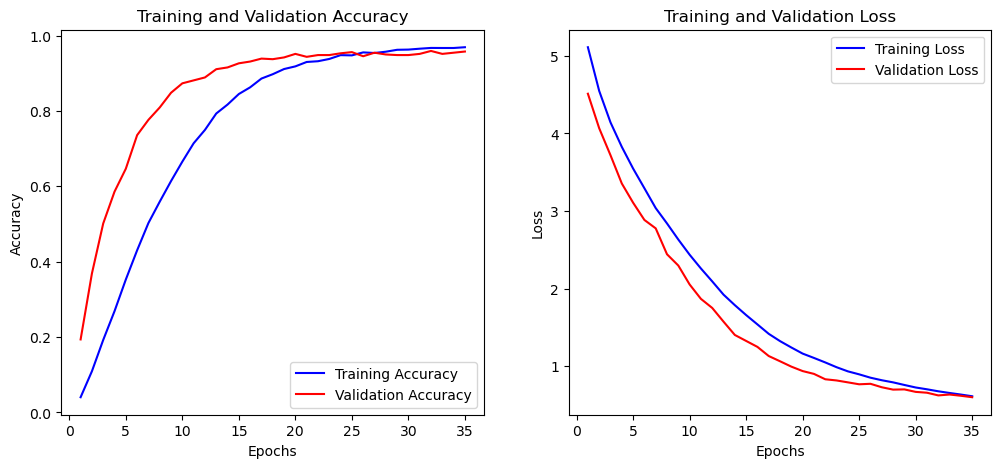

In [11]:
import matplotlib.pyplot as plt

# Plot training history
def plot_history(history):
    # Get history data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to visualize training
plot_history(history)


In [12]:

loss0, accuracy0 = model.evaluate(val_dataset, steps=validation_steps)
print(f"Initial Validation Loss: {loss0}")
print(f"Initial Validation Accuracy: {accuracy0}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 919ms/step - accuracy: 0.9565 - loss: 0.5818
Initial Validation Loss: 0.602790892124176
Initial Validation Accuracy: 0.957812488079071


In [13]:
loss0, accuracy0 = model.evaluate(test_dataset)
print(f"Initial test Loss: {loss0}")
print(f"Initial test Accuracy: {accuracy0}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 901ms/step - accuracy: 0.9576 - loss: 0.5736
Initial test Loss: 0.5920295715332031
Initial test Accuracy: 0.9564706087112427


In [14]:
model.save("E35_D3_LeakyRelu.h5")